,Target,Predictions
Date,,
2024-04-17 00:00:00+00:00,0,0.0
2024-04-18 00:00:00+00:00,1,1.0
2024-04-19 00:00:00+00:00,1,0.0
2024-04-20 00:00:00+00:00,1,0.0
2024-04-21 00:00:00+00:00,0,0.0
...,...,...
2024-06-14 00:00:00+00:00,0,0.0
2024-06-15 00:00:00+00:00,1,0.0
2024-06-16 00:00:00+00:00,1,0.0


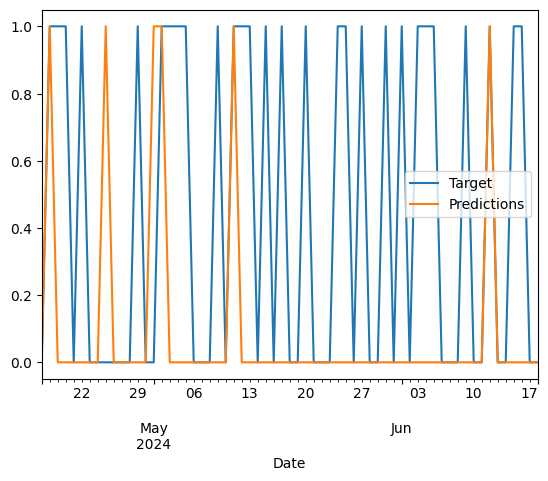

In [2]:
import yfinance as yf

#Ticker for stock
btc = yf.Ticker("BTC-CAD")

btc = btc.history(period="max")

# Graph bitcoin price
# btc.plot.line(y="Close", use_index=True)
del btc["Dividends"]
del btc["Stock Splits"]
btc["Tomorrow"] = btc["Close"].shift(-1)
btc["Target"] = (btc["Tomorrow"]>btc["Close"]).astype(int)

# Display chart of bitcoin price
btc

from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

train = btc.iloc[:-100]
test = btc.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

from sklearn.metrics import precision_score
import pandas as pd

# preds = pd.Series(preds, index=test.index)
# precision_score(test["Target"], preds)
# combined = pd.concat([test["Target"], preds], axis=1)

# combined.plot()

# def predict(train, test, predictors, model):
#     model.fit(train[predictors], train["Target"])
#     preds = model.predict(test[predictors])
#     preds = pd.Series(preds, index=test.index, name="Predictions")
#     combined = pd.concat([test["Target"], preds], axis=1)
#     return combined

#Backtesting

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

# predictions = backtest(btc, model, predictors)

# predictions["Predictions"].value_counts()

# precision_score(predictions["Target"], predictions["Predictions"])

# predictions["Target"].value_counts()/predictions.shape[0]

# Rolling means
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = btc.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    btc[ratio_column] = btc["Close"]/rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    btc[trend_column] = btc.shift(1).rolling(horizon).sum()['Target']

    new_predictors += [ratio_column, trend_column]

btc = btc.dropna()

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds>=.6] = 1
    preds[preds<.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

predictions = backtest(btc, model, new_predictors)
predictions["Predictions"].value_counts()
predictions.plot()
predictions
# score of 67% accuracy
# precision_score(predictions["Target"], predictions["Predictions"])